# 패키지 불러오기

In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse)
library(skimr)
library(GGally)
library(plotly)
library(viridis)
library(caret)
library(DT)
library(data.table)
library(lightgbm)
library(xgboost)
library(kableExtra)
library(magrittr)
set.seed(0)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout


The following object is masked from ‘package:httr’:

    config


Loading required package: viridisLite

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    p

[1] "home-credit-default-risk"

## 데이터 불러오기 
- 각각의 데이터를 불러오도록 한다. 

In [2]:
cat("Loading data...\n")
DATA_PATH = "../input/home-credit-default-risk/"
na_strings = c("NA", "NaN", "?", "")
train = fread(paste0(DATA_PATH, 'application_train.csv'), 
              stringsAsFactors = FALSE, 
              data.table = FALSE, na.strings = na_strings)

# train %>% skim()
dim(train)

Loading data...


[1] 307511    122

In [3]:
test = fread(paste0(DATA_PATH, 'application_test.csv'), 
              stringsAsFactors = FALSE, 
              data.table = FALSE, na.strings = na_strings)

# train %>% skim()
dim(test)

[1] 48744   121

In [4]:
bureau = fread(paste0(DATA_PATH, 'bureau.csv'), 
              stringsAsFactors = FALSE, 
              data.table = FALSE, na.strings = na_strings)

dim(bureau)

[1] 1716428      17

In [5]:
bur_balance = fread(paste0(DATA_PATH, 'bureau_balance.csv'), 
              stringsAsFactors = FALSE, 
              data.table = FALSE, na.strings = na_strings)

dim(bur_balance)
# bur_balance %>% skim()

[1] 27299925        3

# 데이터 전처리
## 데이터 특징
- 모델링을 위한 데이터 전처리에서 가장 기본이 되는 train 데이터의 id를 확인해보면, 각 ID당 1개의 행(row)만 존재하는 것을 확인할 수 있다. 

In [6]:
table(train$SK_ID_CURR) %>% head(10)


100002 100003 100004 100006 100007 100008 100009 100010 100011 100012 
     1      1      1      1      1      1      1      1      1      1 

- 그런데, 다른 데이터셋의 경우, ID마다 서로 다른 행(row) 개수가 나타나는 것을 볼 수 있다. 
- 이 때에는 우선 ID마다 Group by를 통해서 행의 결과를 단일하게 맞출 필요가 있다.

In [7]:
table(bur_balance$SK_ID_BUREAU) %>% head(10)


5001709 5001710 5001711 5001712 5001713 5001714 5001715 5001716 5001717 5001718 
     97      83       4      19      22      15      60      86      22      39 

## sum_bureau_balance
- 우선 bur_balance 데이터는 매월마다 대출 잔액을 체크하고 있다. 
- 이와 같은 데이터에 대한 설명을 이해하는 것은 쉬운 건 아니다. 
  + 이럴 때는 각 데이터에 대한 부가적인 설명이 필요하다. 
  + [Discussion: Interpreting the BUREAU_BALANCE table](https://www.kaggle.com/c/home-credit-default-risk/discussion/58445)
- 우선, STATUS는 데이터 중에서도 서열측도에 해당한다고 볼 수 있다. 
  + 따라서 문자열 데이터를 숫자로 바꾸는 코드를 진행한다. 

In [8]:
cat("Processing...\n")
stat_fn = list(mean = mean, sd = sd)

sum_bur_balance = bur_balance %>% 
  mutate_if(is.character, funs(factor(.) %>% as.integer)) %>% # Ordinal Encoding
  group_by(SK_ID_BUREAU) %>% 
  mutate(SK_ID_BUREAU = as.character(SK_ID_BUREAU)) %>% 
  summarise_all(stat_fn, na.rm = TRUE) 

rm(bur_balance); gc()

sum_bureau = bureau %>% 
  mutate(SK_ID_BUREAU = as.character(SK_ID_BUREAU)) %>% 
  left_join(sum_bur_balance, by = "SK_ID_BUREAU") %>% 
  select(-SK_ID_BUREAU) %>% 
  mutate_if(is.character, funs(factor(.) %>% as.integer)) %>% 
  group_by(SK_ID_CURR) %>% 
  summarise_all(stat_fn)

rm(bureau, sum_bur_balance); gc()

Processing...


Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.”


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,3374263,180.3,9377772,500.9,11722215,626.1
Vcells,100048950,763.4,309727414,2363.1,332688691,2538.3


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2574041,137.5,21261592,1135.5,26576990,1419.4
Vcells,83451980,636.7,247781932,1890.5,332688691,2538.3


# 데이터 합치기
- 이제 데이터를 합치도록 한다. 
- 각 ID가 숫자로 되어 있기 때문에 문자로 변경한다. 
- 각각의 데이터를 분리 하도록 한다. 

In [9]:
train$SK_ID_CURR = as.character(train$SK_ID_CURR)
test$SK_ID_CURR = as.character(test$SK_ID_CURR)
sum_bureau$SK_ID_CURR = as.character(sum_bureau$SK_ID_CURR)

tri = 1:nrow(train)
y = train$TARGET
length(y); length(tri)

[1] 307511

[1] 307511

- 우선 `test 데이터`와 합쳐야 하기 때문에 test 데이터에는 없는 TARGET은 먼저 삭제 한다. 
- 365243 days는 1000년 이상을 의미한다. 즉, 일종의 극단 값이기 때문에, NA로 취급했다. 
- 각 데이터 상의 비율 또는 Percent를 측정하는 코드를 작성했다. 

In [10]:
train_test = train %>% 
  dplyr::select(-TARGET) %>% 
  bind_rows(test) %>% 
  left_join(sum_bureau, by = "SK_ID_CURR") %>% 
  select(-SK_ID_CURR) %>% 
  mutate_if(is.character, funs(factor(.) %>% as.integer)) %>% 
    mutate(na = apply(., 1, function(x) sum(is.na(x))),
         DAYS_EMPLOYED = ifelse(DAYS_EMPLOYED == 365243, NA, DAYS_EMPLOYED),
         DAYS_EMPLOYED_PERC = sqrt(DAYS_EMPLOYED / DAYS_BIRTH),
         INCOME_CREDIT_PERC = AMT_INCOME_TOTAL / AMT_CREDIT,
         INCOME_PER_PERSON = log1p(AMT_INCOME_TOTAL / CNT_FAM_MEMBERS),
         ANNUITY_INCOME_PERC = sqrt(AMT_ANNUITY / (1 + AMT_INCOME_TOTAL)),
         LOAN_INCOME_RATIO = AMT_CREDIT / AMT_INCOME_TOTAL,
         ANNUITY_LENGTH = AMT_CREDIT / AMT_ANNUITY,
         CHILDREN_RATIO = CNT_CHILDREN / CNT_FAM_MEMBERS, 
         CREDIT_TO_GOODS_RATIO = AMT_CREDIT / AMT_GOODS_PRICE,
         INC_PER_CHLD = AMT_INCOME_TOTAL / (1 + CNT_CHILDREN),
         SOURCES_PROD = EXT_SOURCE_1 * EXT_SOURCE_2 * EXT_SOURCE_3,
         CAR_TO_BIRTH_RATIO = OWN_CAR_AGE / DAYS_BIRTH,
         CAR_TO_EMPLOY_RATIO = OWN_CAR_AGE / DAYS_EMPLOYED,
         PHONE_TO_BIRTH_RATIO = DAYS_LAST_PHONE_CHANGE / DAYS_BIRTH,
         PHONE_TO_EMPLOY_RATIO = DAYS_LAST_PHONE_CHANGE / DAYS_EMPLOYED) 

train_test %>% glimpse()

Rows: 356,255
Columns: 173
$ NAME_CONTRACT_TYPE           <int> 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,…
$ CODE_GENDER                  <int> 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2,…
$ FLAG_OWN_CAR                 <int> 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2,…
$ FLAG_OWN_REALTY              <int> 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,…
$ CNT_CHILDREN                 <int> 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,…
$ AMT_INCOME_TOTAL             <dbl> 202500.00, 270000.00, 67500.00, 135000.00…
$ AMT_CREDIT                   <dbl> 406597.5, 1293502.5, 135000.0, 312682.5, …
$ AMT_ANNUITY                  <dbl> 24700.5, 35698.5, 6750.0, 29686.5, 21865.…
$ AMT_GOODS_PRICE              <dbl> 351000, 1129500, 135000, 297000, 513000, …
$ NAME_TYPE_SUITE              <int> 7, 2, 7, 7, 7, 6, 7, 7, 1, 7, 7, 1, 7, 7,…
$ NAME_INCOME_TYPE             <int> 8, 5, 8, 8, 8, 5, 2, 5, 4, 8, 8, 4, 8, 8,…
$ NAME_EDUCATION_TYPE          <int> 5, 2, 5, 5, 5, 5, 2, 2, 5, 5, 2, 5, 5, 5,…
$ NAME_FAMILY

## FLAG_DOC 
- FLAG_DOC은 고객의 문서 제공 횟수를 의미한다. 
- 이 데이터에서 `ORGANIZATION_TYPE`에 따른 `AMT_INCOME_TOTAL` 중간값을 구하도록 했다. 

In [11]:
docs = str_subset(names(train), "FLAG_DOC")
live = str_subset(names(train), "(?!NFLAG_)(?!FLAG_DOC)(?!_FLAG_)FLAG_")

inc_by_org <- train_test %>% 
  group_by(ORGANIZATION_TYPE) %>% 
  summarise(m = median(AMT_INCOME_TOTAL)) %$% 
  setNames(as.list(m), ORGANIZATION_TYPE)

inc_by_org[1:5]

$`1`
[1] 166500

$`2`
[1] 135000

$`3`
[1] 166500

$`4`
[1] 157500

$`5`
[1] 157500

### 데이터 병합 및 Matrix 변환
- 몇가지 문법적인 내용을 소개한다. 

In [12]:
library(forcats)

level_key <- c(a = "apple", b = "banana", c = "carrot")
char_vec <- sample(c("a", "b", "c"), 10, replace = TRUE)
recode(char_vec, !!!level_key)

[1] "banana" "apple"  "carrot" "apple"  "banana" "apple"  "carrot" "carrot"
 [9] "banana" "banana"

- named vector를 적용할 때는 !!!를 추가로 입력한다. 
  + 관련 내용: https://adv-r.hadley.nz/quasiquotation.html

- moments 패키지 내, 첨도(kurtosis)는 평균을 중심으로 얼마나 뾰족하게 분포되어 있는지를 나타냄. 양의 값일 경우 분포가 뾰족하고 음의 값일 경우 분포가 평평함.

In [13]:
final_df <- train_test %>% 
  mutate(DOC_IND_KURT = apply(train_test[, docs], 1, moments::kurtosis),
         LIVE_IND_SUM = apply(train_test[, live], 1, sum),
         NEW_INC_BY_ORG = recode(train_test$ORGANIZATION_TYPE, !!!inc_by_org),
         NEW_EXT_SOURCES_MEAN = apply(train_test[, c("EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3")], 1, mean),
         NEW_SCORES_STD = apply(train_test[, c("EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3")], 1, sd))%>%
  mutate_all(funs(ifelse(is.nan(.), NA, .))) %>% 
  mutate_all(funs(ifelse(is.infinite(.), NA, .))) %>% 
  data.matrix()

length(final_df)

[1] 63413390

# 모델링 

## XGBoost

In [14]:
cat("Modeling data...\n")
length(final_df)
dtest <- xgb.DMatrix(data = final_df[-tri, ])

tr_te <- final_df[tri, ]
train_split <- caret::createDataPartition(y, p = 0.9, list = F) %>% c()
dtrain <- xgb.DMatrix(data = tr_te[train_split, ], label = y[train_split])
dval <- xgb.DMatrix(data = tr_te[-train_split, ], label = y[-train_split])
cols <- colnames(final_df)

Modeling data...


[1] 63413390

- 모형학습을 진행한다. 

[17:07:40] WARNING: amalgamation/../src/learner.cc:573: 
Parameters: { "nrounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[1]	val-auc:0.701059 
Will train until val_auc hasn't improved in 300 rounds.

[51]	val-auc:0.750763 
[100]	val-auc:0.762798 


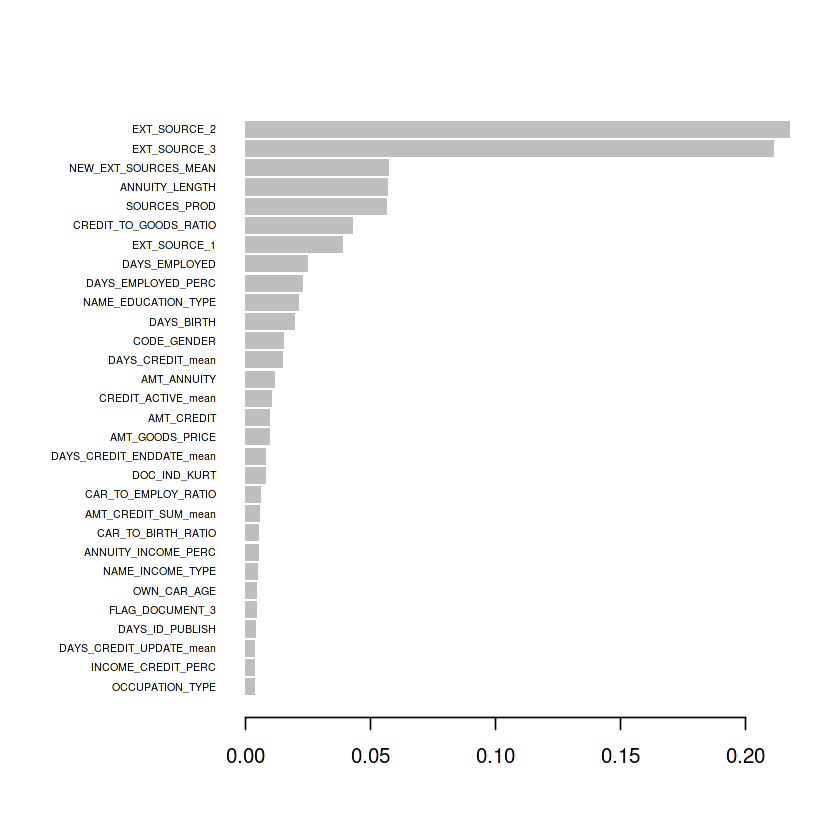

In [15]:
p <- list(objective = "binary:logistic",
          booster = "gbtree",
          eval_metric = "auc",
          nthread = 6, 
          eta = 0.05,
          max_depth = 6,
          min_child_weight = 30,
          gamma = 0,
          subsample = 0.85,
          colsample_bytree = 0.7,
          colsample_bylevel = 0.632,
          alpha = 0,
          lambda = 0,
          nrounds = 100) # 3000

set.seed(0)
m_xgb <- xgb.train(p, dtrain, p$nrounds, list(val = dval), print_every_n = 50, early_stopping_rounds = 300)

xgb.importance(cols, model=m_xgb) %>% 
  xgb.plot.importance(top_n = 30)

## LightGBM

- 데이터를 준비한다. 

In [16]:
cat("Modeling data...\n")
length(final_df)
dtest <- final_df[-tri, ]

tr_te <- final_df[tri, ] %>% data.matrix()
train_split <- caret::createDataPartition(y, p = 0.9, list = F) %>% c()
dtrain <- lgb.Dataset(data = tr_te[train_split, ], label = y[train_split])
dval <- lgb.Dataset(data = tr_te[-train_split, ], label = y[-train_split])
cols <- colnames(final_df)

Modeling data...


[1] 63413390

[1]:	val's auc:0.690558 
[51]:	val's auc:0.725036 
[101]:	val's auc:0.737551 
[151]:	val's auc:0.744657 
[201]:	val's auc:0.749136 
[251]:	val's auc:0.75183 
[301]:	val's auc:0.753944 
[351]:	val's auc:0.755925 
[401]:	val's auc:0.757466 
[451]:	val's auc:0.758934 
[501]:	val's auc:0.760214 
[551]:	val's auc:0.761306 
[601]:	val's auc:0.762116 
[651]:	val's auc:0.762808 
[701]:	val's auc:0.763434 
[751]:	val's auc:0.764018 
[801]:	val's auc:0.764443 
[851]:	val's auc:0.764838 
[901]:	val's auc:0.765227 
[951]:	val's auc:0.765579 
[1001]:	val's auc:0.765993 
[1051]:	val's auc:0.766197 
[1101]:	val's auc:0.766682 
[1151]:	val's auc:0.766965 
[1201]:	val's auc:0.767164 
[1251]:	val's auc:0.767414 
[1301]:	val's auc:0.767687 
[1351]:	val's auc:0.767887 
[1401]:	val's auc:0.768104 
[1451]:	val's auc:0.768226 
[1501]:	val's auc:0.768372 
[1551]:	val's auc:0.768564 
[1601]:	val's auc:0.768821 
[1651]:	val's auc:0.768953 
[1701]:	val's auc:0.769173 
[1751]:	val's auc:0.769307 
[1801]:	val's au

<table>
 <thead>
  <tr>
   <th style="text-align:left;"> Feature </th>
   <th style="text-align:right;"> Gain </th>
   <th style="text-align:right;"> Cover </th>
   <th style="text-align:right;"> Frequency </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:left;"> EXT_SOURCE_3 </td>
   <td style="text-align:right;"> 0.2215894 </td>
   <td style="text-align:right;"> 0.0433836 </td>
   <td style="text-align:right;"> 0.0461444 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> EXT_SOURCE_2 </td>
   <td style="text-align:right;"> 0.2096653 </td>
   <td style="text-align:right;"> 0.0354669 </td>
   <td style="text-align:right;"> 0.0347059 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> ANNUITY_LENGTH </td>
   <td style="text-align:right;"> 0.0759017 </td>
   <td style="text-align:right;"> 0.1136182 </td>
   <td style="text-align:right;"> 0.0918982 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> EXT_SOURCE_1 </td>
   <td style="text-align:right;"> 0.0526588 </td>


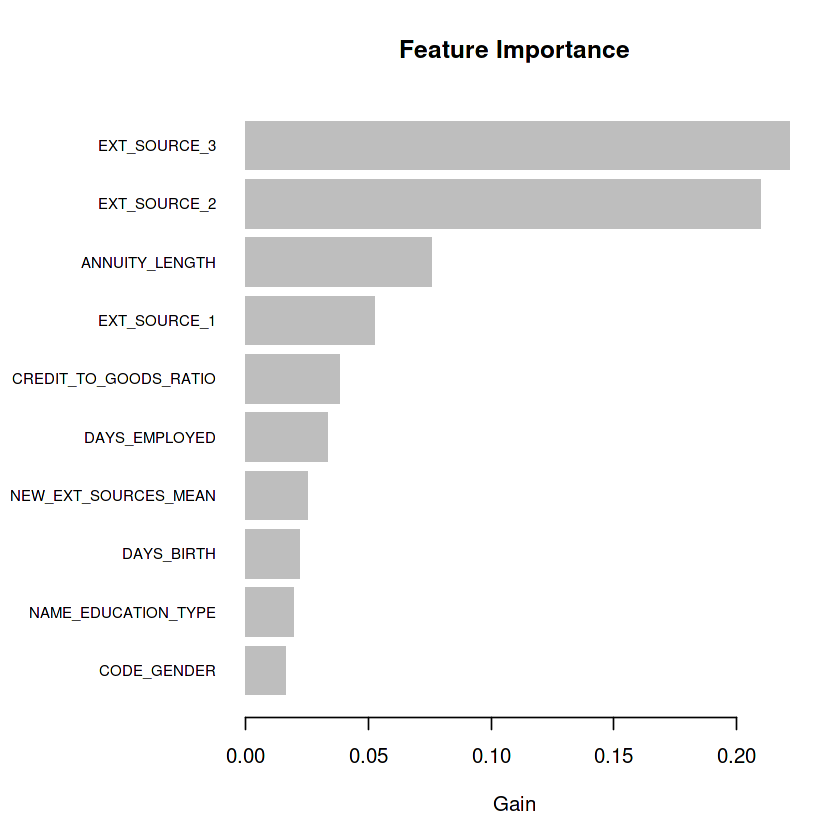

In [17]:
params.lgb = list(
    objective = "binary"
    , booster = "gbtree"
    , metric = "auc"
    , min_data_in_leaf = 1
    , min_sum_hessian_in_leaf = 100
    , feature_fraction = 0.9
    , bagging_fraction = 0.9
    , bagging_freq = 0
    , nthread = 4 
    , eta = 0.05
    , max_depth = 8,
    min_child_weight = 22,
    colsample_bytree = 0.9497036,
    colsample_bylevel = 0.7
  )

lgb.model <- lgb.train(
      params = params.lgb
      , data = dtrain
      , valids = list(val = dval)
      , learning_rate = 0.02
      , num_leaves = 7
      , num_threads = 2
      , nrounds = 3000  
      , early_stopping_rounds = 200
      , eval_freq = 50
    )
    
# get feature importance
lgb.importance(lgb.model, percentage = TRUE) %>% head(20) %>% kable()
tree_imp <- lgb.importance(lgb.model, percentage = TRUE) %>% head(20)
lgb.plot.importance(tree_imp, measure = "Gain")

# 결괏값 제출

- XGBoost

In [18]:
# read_csv(paste0(DATA_PATH, "sample_submission.csv")) %>%  
#   mutate(SK_ID_CURR = as.integer(SK_ID_CURR),
#          TARGET = predict(m_xgb, dtest)) %>%
#  write_csv("submission.csv")

- LightGBM

In [19]:
read_csv(paste0(DATA_PATH, "sample_submission.csv")) %>% 
    mutate(SK_ID_CURR = as.integer(SK_ID_CURR), 
           TARGET = predict(lgb.model, data = dtest, n = lgb.model$best_score)) %>%
    write_csv("submission.csv")

Rows: 48744 Columns: 2

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (2): SK_ID_CURR, TARGET


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

